## Offline tests

Imports


In [66]:
%load_ext autoreload
%autoreload 2

from libemg.streamers import delsys_streamer 
from libemg.data_handler import OnlineDataHandler, OfflineDataHandler, RegexFilter, FilePackager
from libemg.feature_extractor import FeatureExtractor
from libemg.emg_predictor import EMGRegressor, OnlineEMGRegressor, EMGClassifier
from libemg.offline_metrics import OfflineMetrics
import re, json, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from pathlib import Path



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Helper Functions

In [60]:
# Had to copy it here cause it didn't work when imported
class FlutterRejectionFilter:
    """
    From source.controller.py
    """
    def __init__(self, tanh_gain=0.5, dt=0.01, integrator_enabled=False, gain=1.0, k=0.0):
        """
        Nonlinear flutter rejection filter with gain, deadband and optional integrator

        Parameters:
        -------------
        tanh_gain : float 
            The scaling factor for the tanh function. A lower tanh_gain makes the nonlinear filter more linear/gradual.
        dt : float 
            The time constant for the integrator (affects smoothness).
        integrator_enabled : bool
            If True, the filter will include an integrator to smooth the output.
        gain : float
            Gain applied to the output to scale the response.
        k : float
            New parameter, doesn't know how it make the system response
        """
        self.tanh_gain = tanh_gain
        self.dt = dt
        self.integrator_enabled = integrator_enabled
        self.state = None # Initialize the state for the integrator
        self.gain = gain
        self.k = k


    ## Updated version of filter
    def reset_integrator(self):
        """ Reset the filter state to zero. """
        if self.state is not None:
            self.state[:] = 0.0

    def filter(self, x):
        x = np.asarray(x)
        if self.state is None:
            self.state = np.zeros_like(x)
        print(f"Input: {x}")
        #print(f"State: {self.state}")
        nonlinear_output = (np.abs(x)-self.k) * np.tanh(self.tanh_gain * x)
        #print(f"Nonlinear Output: {nonlinear_output}")
        self.state += nonlinear_output * self.dt
        
        if self.integrator_enabled:
            print(f"Output with integrator: {self.gain*self.state}")
            return self.gain*self.state
        else:
            return self.gain*nonlinear_output
        
class PostPredictionController:
    def __init__(self, gain_mf1=1.0, gain_mf2=1.0, thr_angle_mf1=45, thr_angle_mf2=45, deadband_radius=0.0):
        """
        Post-prediction controller to scale the output of the prediction model.

        Parameters:
        -------------
        gain (float): Gain applied to the output to scale the response.
        """
        self.gain_mf1 = gain_mf1
        self.gain_mf2 = gain_mf2
        self.thr_angle_mf1 = thr_angle_mf1
        self.thr_angle_mf2 = thr_angle_mf2
        self.deadband_radius = deadband_radius

    def update_config(self, gain_mf1=None, gain_mf2=None, thr_angle_mf1=None, thr_angle_mf2=None, deadband_radius=None):
        """
        Set the configuration for the prosthetic device. NOTE! Could add checks here as well to ensure the values are within a certain range, or if they are valid values.
        Parameters:
        ----------
            gains: List of gains for each motor function (list of floats).
            thr_angle_mf1: Threshold angle for motor function 1 (float).
            thr_angle_mf2: Threshold angle for motor function 2 (float).
            deadband: Deadband value (float).
        """
        if gain_mf1:
            self.gain_mf1 = gain_mf1
        if gain_mf2:
            self.gain_mf2 = gain_mf2
        #if thr_angle_mf1:
        #    self.thr_angle_mf1 = thr_angle_mf1
        #if thr_angle_mf2:
        #    self.thr_angle_mf2 = thr_angle_mf2
        if deadband_radius:
            self.deadband_radius = deadband_radius


    def apply_gains(self, prediction):
        """Apply gain to each prediction value."""
        return np.array([
            prediction[0] * self.gain_mf1,
            prediction[1] * self.gain_mf2
        ])

    def apply_deadband(self, prediction):
        """Zero out values within the deadband radius."""
        return np.array([
            0 if abs(prediction[0]) < self.deadband_radius else prediction[0],
            0 if abs(prediction[1]) < self.deadband_radius else prediction[1]
        ])

    def update_prediction(self, prediction):
        """
        Update the prediction by applying gains and deadband.

        Parameters:
        -------------
        prediction (list): The input prediction signal.

        Returns:
        list: The updated prediction signal.
        """
        # Apply gain
        prediction = self.apply_gains(prediction)
        
        # Apply deadband
        prediction = self.apply_deadband(prediction)

        return prediction
    
def _match_metadata_to_data(metadata_file: str, data_file: str, class_map: dict) -> bool:
        """
        Ensures the correct animation metadata file is matched with the correct EMG data file.

        Args:
            metadata_file (str): Metadata file path (e.g., "animation/collection_hand_open_close.txt").
            data_file (str): EMG data file path (e.g., "data/regression/C_0_R_01_emg.csv").
            class_map (dict): Dictionary mapping class index (str) to motion filenames.

        Returns:
            bool: True if the metadata file corresponds to the class of the data file.
        """
        # Extract class index from data filename (C_{k}_R pattern)
        match = re.search(r"C_(\d+)_R", data_file)
        if not match:
            return False  # No valid class index found

        class_index = match.group(1)  # Extract class index as a string

        # Find the expected metadata file from class_map
        expected_metadata = class_map.get(class_index)
        if not expected_metadata:
            return False  # No matching motion found

        # Construct the expected metadata filename
        expected_metadata_file = f"../animation/{expected_metadata}.txt"

        return metadata_file == expected_metadata_file


### Set parameters

In [118]:
WINDOW_SIZE = 200       # 100 ms * 2000Hz = 200 samples
WINDOW_INCREMENT = 100   # 50 ms * 2000Hz = 10 samples
regression_selected = True
plot_emg = True
plot_features = True
# Dataset options
training_datafolder = "data/regression/22-05/anders"
save_folder = "./plots/regression/anders/ch2-rep3-pronation"
active_channels = [0] #,1,2,3,4]   # 5 Sensors used in anders dataset
train_reps = [3]     # total of 6 reps each class
test_reps = [4,5]           # total of 6 reps each class
active_classes = [2]#,1,2,3,4]    # total of 5 motion classes

# Feature extraction parameters
desired_features = ['MAV']

ml_models = ["GB"]

# Filter parameters
tanh_gain = 0.5 
dt = 0.01
gain = 1.0
k = 0.05
filter = FlutterRejectionFilter(tanh_gain=tanh_gain, dt=dt, integrator_enabled=True, gain=gain, k=k)
deadband_radius = 0.3

# Post-prediction controller gains and tresholds
post_pred_adjustment = PostPredictionController(gain_mf1=1.0, gain_mf2=1.0, thr_angle_mf1=45, thr_angle_mf2=45, deadband_radius=deadband_radius)
test_nr = 1


### Extract windows, set up and train model

30 data files fetched out of 391 files.
Plot saved to plots\regression\anders\ch2-rep3-pronation\raw_data.pdf


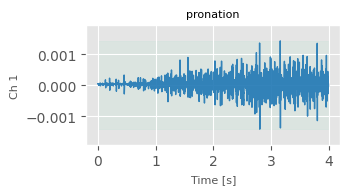

Extracting features


<string>:60: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.


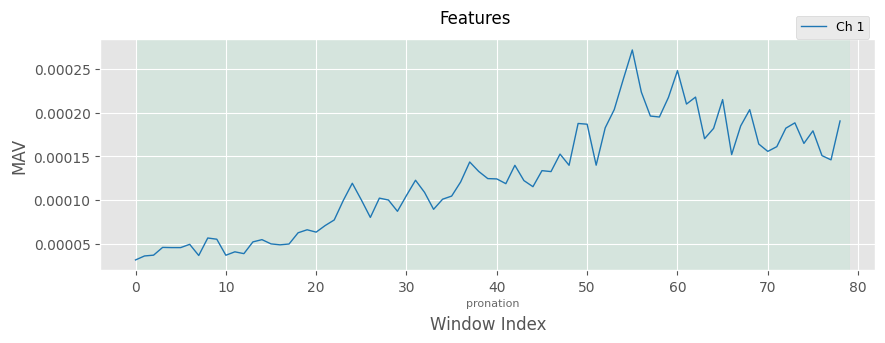

Creating dataset


In [122]:
############ Set up regressor ########
# Step 2.1: Parse offline training data
if regression_selected:
    data_folder = "data/regression/"
else:
    data_folder = "data/classification/"


json_path = os.path.join('..', training_datafolder, "collection_details.json")

with open(json_path, 'r') as f:
    collection_details = json.load(f)

num_motions = collection_details['num_motions']
num_reps = collection_details['num_reps']
motion_names = collection_details['classes']
class_map = collection_details['class_map']
active_class_map = {str(i): motion_names[i] for i in active_classes}

regex_filters = [
        RegexFilter(
            left_bound = f"{training_datafolder}/C_",
            right_bound = "_R",
            values = [str(i) for i in range(num_motions)],
            description = 'classes'
        ),
        RegexFilter(
            left_bound = "R_", 
            right_bound="_emg.csv", 
            values = [str(i) for i in range(num_reps)], 
            description='reps'
        )
    ]
if regression_selected:
    metadata_fetchers = [
        FilePackager(RegexFilter(left_bound='animation/', right_bound='.txt', values=motion_names, description='labels'), package_function=lambda meta, data: _match_metadata_to_data(meta, data, class_map)) 
    ]
    labels_key = 'labels'
    metadata_operations = {'labels': 'last_sample'}
else:
    metadata_fetchers = None
    labels_key = 'classes'
    metadata_operations = None
        
offline_dh = OfflineDataHandler()
offline_dh.get_data('../', regex_filters, metadata_fetchers=metadata_fetchers, delimiter=",")
odh_active_channels = offline_dh.isolate_channels(active_channels)  # Isolate wanted channels
#offline_dh.visualize()    offline_dh_c = OfflineDataHandler()
odh_active_class = odh_active_channels.isolate_data("classes", active_classes) # Only extract wanted classes

class_names = {int(c): class_map[str(c)].replace("collection_", "").replace("_", " ") for c in active_classes}

# Isolate data for training and testing
train_odh = odh_active_class.isolate_data("reps", train_reps)
test_odh = odh_active_class.isolate_data("reps", test_reps)

if plot_emg:
    save_path = save_folder+f"/raw_data.pdf"
    save_path = Path(save_path)
    save_path.parent.mkdir(parents=True, exist_ok=True)
    train_odh.visualize_classes(class_names = class_names, recording_time = 4, save_path=save_path, save_plot=True, title="")
#test_odh.visualize(block=False)
train_windows, train_metadata = train_odh.parse_windows(WINDOW_SIZE, WINDOW_INCREMENT, metadata_operations=metadata_operations)
test_windows, test_metadata = test_odh.parse_windows(WINDOW_SIZE, WINDOW_INCREMENT, metadata_operations=metadata_operations)
# Step 2: Extract features from offline data
fe = FeatureExtractor()
print("Extracting features")
#feature_list = fe.get_feature_list()
#desired_features = ["MAV", "ZC", "WL", "MYOP"] # The same used in Fougner 2012
#feature_list = [f for f in feature_list if f in desired_features]
if desired_features:
    feature_list = desired_features
else:
    feature_list = fe.get_feature_groups()['HTD']
    
training_features = fe.extract_features(feature_list, train_windows, array=True)
test_features = fe.extract_features(feature_list, test_windows, array=True)
test_labels = test_metadata[labels_key]

if plot_features:
    feat_dict = fe.extract_features(feature_list, train_windows, array=False)
    save_path = save_folder+f"/features.pdf"
    save_path = Path(save_path)
    save_path.parent.mkdir(parents=True, exist_ok=True)
    fe.visualize(feat_dict, class_names=class_names, num_reps=len(train_reps), save_path=save_path, save_plot=True)
    # fe.visualize_with_time(
    #     feat_dict, 
    #     sampling_time=4*num_motions*num_reps,
    #     window_increment=int(WINDOW_INCREMENT),
    #     window_size=int(WINDOW_SIZE), 
    #     title="Features",
    #     motion_names=motion_names,
    #     num_reps=num_reps
    # )
    #fe.visualize(feat_dict)
# Step 3: Dataset creation
data_set = {}
print("Creating dataset")
data_set['training_features'] = training_features
data_set['training_labels'] = train_metadata[labels_key]

### Run predictor and plot results

Running GB model
Plotting decision stream. This will block the main thread once the plot is shown. Close the plot to continue.
Input: [ 0.22916341 -0.02067017]
Output with integrator: [2.04394780e-04 3.03115508e-06]
Input: [-0.0049864   0.00619622]
Output with integrator: [2.05517058e-04 1.67407082e-06]
Input: [0.04329316 0.05041432]
Output with integrator: [2.04065484e-04 1.77848774e-06]
Input: [0.10094409 0.00467396]
Output with integrator: [2.29756193e-04 7.19229299e-07]
Input: [0.05838667 0.02812525]
Output with integrator: [ 2.32203847e-04 -2.35673214e-06]
Input: [-0.07990153 -0.06016545]
Output with integrator: [ 2.20264308e-04 -5.41385355e-06]
Input: [-0.79196813 -0.0637448 ]
Output with integrator: [-2.57330167e-03 -9.79316865e-06]
Input: [-0.73407139 -0.00416139]
Output with integrator: [-4.97710222e-03 -8.83940741e-06]
Input: [-0.57295947 -0.00416139]
Output with integrator: [-6.43559200e-03 -7.88564616e-06]
Input: [-0.72668441 -0.03829251]
Output with integrator: [-8.7914994

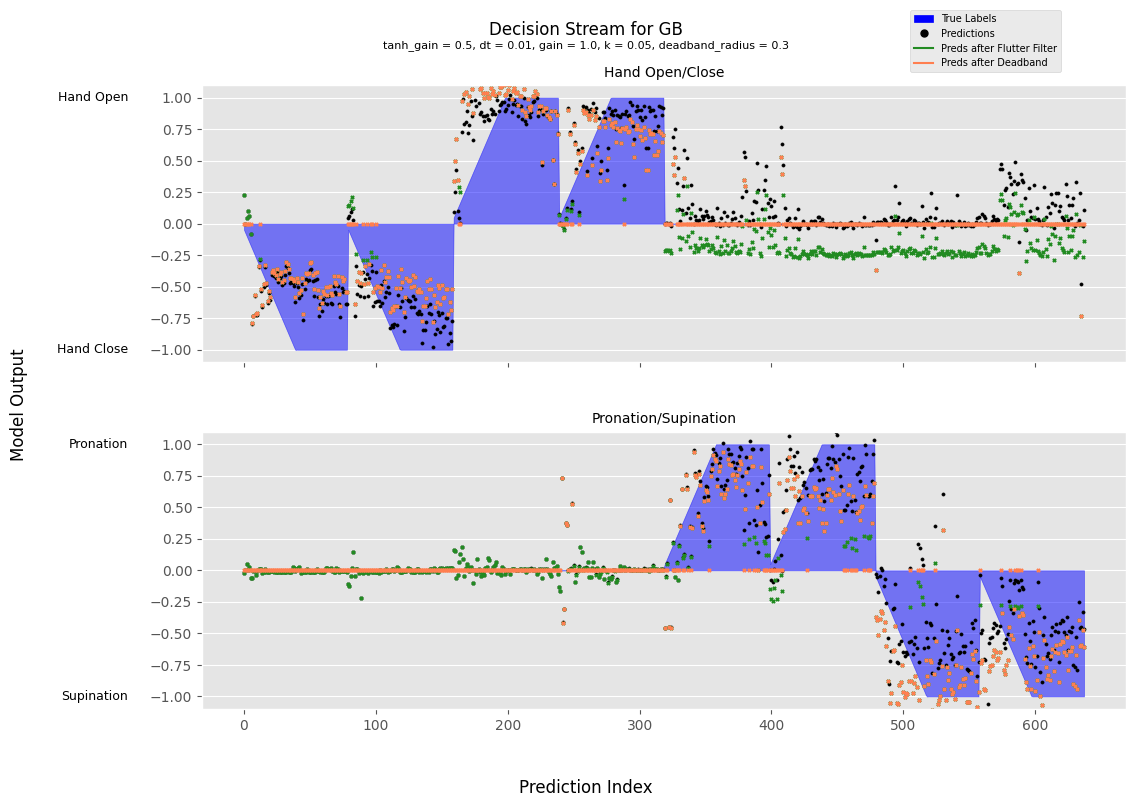

Result for  metric R2: [0.7901148583879497, 0.7304875163576114]
Result for  metric NRMSE: [0.13252174634667904, 0.1507293210470055]
Result for  metric MAE: [0.17113788772546806, 0.2227108895828836]


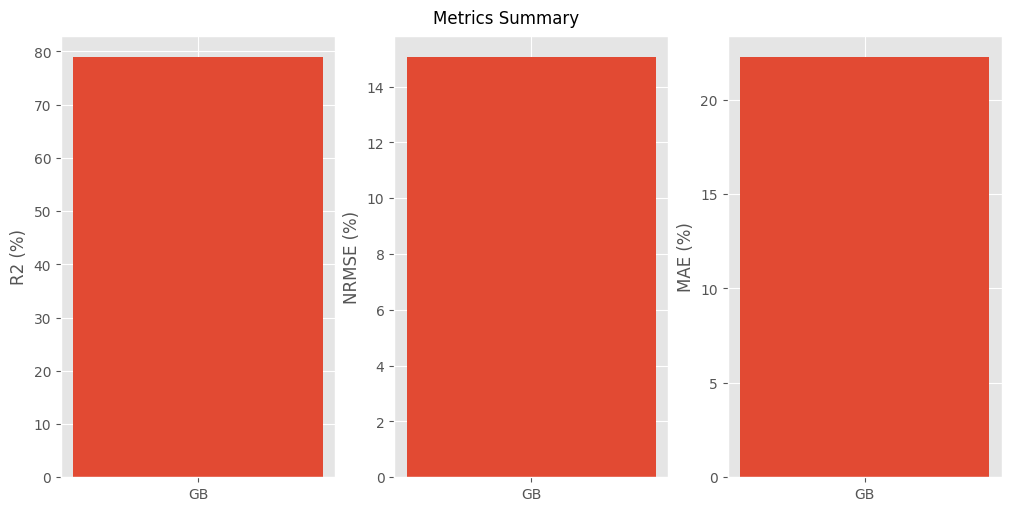

In [ ]:
if regression_selected:
    ######## REGRESSOR ########
    # Step 4.2: Create the Regressor model
    models = ml_models # Make this chosen from the GUI later 'LR', 'SVM', 'RF', 'GB', 'MLP'
    results = {metric: [] for metric in ['R2', 'NRMSE', 'MAE']}
    om = OfflineMetrics()
    for model in models:
        print(f"Running {model} model")
        emg_model = EMGRegressor(model=model)
        #emg_model.install_filter(filter) #NOTE"! Made this filter 21.05 but doesn't make sense to do integration on the testdata like this, need to split it
        #emg_model.add_deadband(threshold=0.3)
        emg_model.fit(feature_dictionary=data_set)
        preds = emg_model.run(test_features)
        #filtered_preds = filter.update(preds)
        # Extract metrics for each classifier
        metrics = om.extract_offline_metrics(results.keys(), test_labels, preds)
        for metric in metrics:
            results[metric].append(metrics[metric].mean())
            
        print('Plotting decision stream. This will block the main thread once the plot is shown. Close the plot to continue.') 
        #emg_model.visualize(test_labels=test_labels, predictions=preds, save_path=f"./plots/21-05/ML-results/HTDfeatures/{model}_offline_decision_stream-filtered-{test_nr}.png", save_plot=True)
        filtered_preds = []
        gained_preds = []
        for i in range(test_features.shape[0]):
            pred = preds[i]
            flutter_pred = filter.filter(pred)
            filtered_pred = pred-flutter_pred
            gained_pred = post_pred_adjustment.update_prediction(filtered_pred)
            filtered_preds.append(filtered_pred)
            gained_preds.append(gained_pred)

        filtered_preds = np.array(filtered_preds)
        gained_preds = np.array(gained_preds)
        metrics = om.extract_offline_metrics(results.keys(), test_labels, filtered_preds)
        for metric in metrics:
            results[metric].append(metrics[metric].mean())

        plt.style.use('ggplot')
        fig, axs = plt.subplots(nrows=test_labels.shape[1], ncols=1, sharex=True, figsize=(12, 8)) #, layout='constrained'
        # Add spacing manually instead of relying on layout='constrained'
        fig.subplots_adjust(top=0.90, 
                            bottom=0.12, 
                            left=0.18, 
                            right=0.95, 
                            hspace=0.25)
        fig.suptitle(f'Decision Stream for {model}', x=0.5, fontsize = 12)
        # Add descriptive y-axis meaning as a figure-level subtitle
        fig.text(0.5, 0.95, f'tanh_gain = {tanh_gain}, dt = {dt}, gain = {gain}, k = {k}, deadband_radius = {deadband_radius}', ha='center', va='center', fontsize=8)
        fig.supxlabel('Prediction Index')
        fig.supylabel('Model Output')

        marker_size = 5
        pred_color = 'black'
        filtered_pred_color = 'forestgreen'
        gained_pred_color = 'coral'
        label_color = 'blue'
        x = np.arange(test_labels.shape[0])
        handles = [mpatches.Patch(color=label_color, label='True Labels'), 
                    mlines.Line2D([], [], color=pred_color, marker='o', markersize=marker_size, linestyle='None', label='Predictions'),
                    mlines.Line2D([], [], color=filtered_pred_color, linestyle='-', label='Preds after Flutter Filter'),
                    mlines.Line2D([], [], color=gained_pred_color, linestyle='-', label='Preds after Deadband')]               
        for dof_idx, ax in enumerate(axs):
            if dof_idx == 0:
                title = "Hand Open/Close"
                ax.text(-0.08, 1, 'Hand Open', va='center', ha='right', transform=ax.get_yaxis_transform(), fontsize=9)
                ax.text(-0.08, -1, 'Hand Close', va='center', ha='right', transform=ax.get_yaxis_transform(), fontsize=9)
            elif dof_idx == 1:
                title = "Pronation/Supination"
                ax.text(-0.08, 1, 'Pronation', va='center', ha='right', transform=ax.get_yaxis_transform(), fontsize=9)
                ax.text(-0.08, -1, 'Supination', va='center', ha='right', transform=ax.get_yaxis_transform(), fontsize=9)

            ax.set_title(title, fontsize=10)
            ax.set_ylim((-1.1, 1.1))
            ax.xaxis.grid(False)
            ax.fill_between(x, test_labels[:, dof_idx], alpha=0.5, color=label_color)
            ax.scatter(x, preds[:, dof_idx], color=pred_color, s=marker_size, label='Preds')
            ax.scatter(x, filtered_preds[:, dof_idx], color=filtered_pred_color, s=marker_size, marker='x', label='Preds after Flutter Filter')
            ax.scatter(x, gained_preds[:, dof_idx], color=gained_pred_color, s=marker_size, marker='x', label='Preds after Deadband')

        fig.legend(handles=handles,
                    loc='upper right', 
                    fontsize=7, 
                    bbox_to_anchor=(0.9, 1.0))#,   bbox_transform=axs[0].transAxes)
        save_path = f"../plots/21-05/ML-results/HTDfeatures/feedback/GainAndDeadband/{model}_offline_decision_stream-filtered-{test_nr}.pdf"
        save_path = Path(save_path)
        # Ensure save_path exists, creating it if needed
        save_path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(save_path, bbox_inches='tight', dpi=300)            
        plt.show()

    plt.style.use('ggplot')
    fig, axs = plt.subplots(ncols=len(results), layout='constrained', figsize=(10, 5))
    for metric, ax in zip(results.keys(), axs):
        print(f"Result for  metric {metric}:", results[metric])
        ax.bar(models, np.array(results[metric]) * 100, width=0.2)
        ax.set_ylabel(f"{metric} (%)")

    save_path = f"../plots/21-05/ML-results/HTDfeatures/feedback/GainAndDeadband/metrics_summary-filtered-{test_nr}.pdf"
    if not os.path.exists(os.path.dirname(save_path)):
        os.makedirs(os.path.dirname(save_path))
    fig.suptitle('Metrics Summary')
    fig.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()
else:
    ######## CLASSIFIER ########    
    models = ['LDA', 'SVM', 'RF']
    results = {metric: [] for metric in ['CA', 'AER', 'F1', 'PREC', 'RECALL','CONF_MAT']} 
    om = OfflineMetrics()
    for model in models:
        print(f"Running {model} model")
        emg_model = EMGClassifier(model=model)
        emg_model.fit(feature_dictionary=data_set)
        preds, probs = emg_model.run(test_features)
        # Extract metrics for each classifier
        metrics = om.extract_offline_metrics(results.keys(), test_labels, preds, null_label=2) # null-label is for AER, represent the No Movement (rest) class
        for metric in metrics:
            if metric == 'CONF_MAT':
                # Plot confusion matrix separately
                from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
                labels = [f"{i} - {motion_names[i]}" for i in range(num_motions)]
                cm = confusion_matrix(test_labels, preds, labels=None, normalize='pred')
                disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
                disp.plot(xticks_rotation=45)
                disp.ax_.set_title(f"Confusion Matrix - {model}")
                plt.savefig(f"../plots/14-05/classification/classifier-training-protocol/confusion_matrix_{model}.pdf", bbox_inches='tight')
                plt.show()
            results[metric].append(metrics[metric])#.mean())
        print('Plotting decision stream. This will block the main thread once the plot is shown. Close the plot to continue.') 
        #emg_model.visualize(test_labels=test_labels, predictions=preds, probabilities=probs, save_path=f"./plots/14-05/classification/classifier-training/{model}_offline_decision_stream.png", save_plot=True)

    plt.style.use('ggplot')
    fig, axs = plt.subplots(ncols=len(results)-1, layout='constrained', figsize=(10, 5))
    for metric, ax in zip(results.keys(), axs):
        if metric == 'CONF_MAT':
            # Plot confusion matrix separately
            for mat in results[metric]:
                #om.visualize_conf_matrix(mat,labels)
                continue
        else:
            ax.bar(models, np.array(results[metric]) * 100, width=0.2)
            ax.set_ylabel(f"{metric} (%)")

    fig.suptitle('Metrics Summary')
    fig.savefig(f"../plots/14-05/classification/classifier-training-protocol/metrics_summary.pdf", bbox_inches='tight')
    plt.show()

    om.extract_offline_metrics(['CONF_MAT'],test_labels, preds)
